こちらのコードサンプルは AiCutyによる解説です。原作は
[Gemini Native Image generation (aka 🍌Nano-Banana models)](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_Started_Nano_Banana.ipynb)
##### Copyright 2025 Google LLC.


In [9]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AiCutyで学ぶ Gemini Native Image generation (🍌Nano-Banana Pro)

ブログは[こちら](https://j.aicu.ai/251123)

![](https://github.com/aicuai/AiCuty/blob/main/img/aicuty-on-stage-real.png?raw=true)


<a target="_blank" href="https://colab.research.google.com/github/aicuai/AiCuty/blob/main/AiCuty_NanoBananaPro.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

---
> **🍌Nano Banana Pro**: If you are only interested in the new [Gemini 3 Pro Image](https://ai.google.dev/gemini-api/docs/models#gemini-3-pro-image) model, jump directly to the [dedicated section](#nano-banana-pro).

---


このノートブックでは、AiCutyを使ってGemini のネイティブ画像出力機能の使い方を紹介します。

* `gemini-3-pro-image-preview`（別名「nano-banana-pro」）：**思考**機能と **Google 検索** を使用した実世界のデータへのアクセスにより、さらに強力になっています。ダイアグラムやグラウンデッドイメージの作成に特に優れています。さらに、2K および 4K 画像も作成可能です！


<!-- Princing warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#ffe680">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#ffe680">
      <h3><font color=black><font color='#217bfe'><a href="https://ai.google.dev/gemini-api/docs/billing#enable-cloud-billing">Enable billing</font></a> to use Image Generation. This is a pay-as-you-go feature (cf. <a href="https://ai.google.dev/pricing#gemini-2.5-flash-image-preview"><font color='#217bfe'>pricing</font></a>).</font></h3>
    </td>
  </tr>
</table>

[Imagen](./Get_started_imagen.ipynb) モデルも画像生成機能を提供しますが、Image-out 機能は反復的に動作するように開発されているため、方法が若干異なります。そのため、特定の詳細が明確に守られていることを確認し、思い描いた通りの画像になるまで繰り返し処理したい場合は、Image-out が最適です。

両方の機能の詳細と、それぞれの機能を使用するタイミングに関するアドバイスについては、[ドキュメント](https://ai.google.dev/gemini-api/docs/image-generation#choose-a-model) をご覧ください。

## Setup

### Install SDK

In [10]:
%pip install -U -q "google-genai>=1.40.0" # minimum version needed for the aspect ratio

### API キーの設定

以下のセルを実行するには、API キーを `GOOGLE_API_KEY` という名前の Colab Secret に保存する必要があります。API キーをまだお持ちでない、または Colab Secret の作成方法がわからない場合は、[認証 ![画像](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) の例をご覧ください。

In [13]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### SDK クライアントの初期化

新しい SDK では、API キー（または Vertex AI を使用している場合は OAuth）を使用してクライアントを初期化するだけで済みます。モデルは各呼び出しで設定されるようになりました。

In [12]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### モデルを選択

以下の2つのモデルから選択できます。
* `gemini-2.5-flash-image`（別名「nano-banana」）：安価で高速でありながらパワフルです。デフォルトの選択肢としてお勧めです。
* `gemini-3-pro-image-preview`（別名「nano-banana-pro」）：思考力とGoogle検索の精度を備え、2Kおよび4K画像の出力も可能です（[専用セクション](#nano-banana-pro)を参照）。

⭐️このサンプルでは `gemini-3-pro-image-preview` を選んでください！

In [21]:
MODEL_ID = "gemini-3-pro-image-preview" # @param ["gemini-2.5-flash-image", "gemini-3-pro-image-preview"] {"allow-input":true, isTemplate: true}

### Utils

これら2つの関数は、モデルの出力を管理するのに役立ちます。

単純にテキストを生成する場合と比較して、今回は出力が複数の部分で構成され、一部はテキスト、一部は画像になります。また、複数の画像が存在する可能性があるため、最初の1枚で止まることはできないことにも注意が必要です。

In [22]:
from IPython.display import display, Markdown
import pathlib

# Loop over all parts and display them either as text or images
def display_response(response):
  for part in response.parts:
    if part.thought: # We don't want to see the thoughts
      continue
    if part.text:
      display(Markdown(part.text))
    elif image:= part.as_image():
      image.show()

# Save the image
# If there are multiple ones, only the last one will be saved
def save_image(response, path):
  for part in response.parts:
    if image:= part.as_image():
      image.save(path)

## チャットモード（推奨方法）

これまでは単項呼び出しを使用してきましたが、Image-out は実際にはチャットモードで動作するように設計されており、ターンごとに画像を反復処理するのが簡単になります。

In [23]:
chat = client.chats.create(
    model=MODEL_ID,
)

<a name="nano-banana-pro"></a>
## Nano-Banana Pro

Flash版と比べて、Pro版は[**thinking**](#thinking)なので、ユーザーのリクエストをより深く理解できます。どんなに複雑なリクエストでも、Pro版があなたの要望を叶えてくれます。

[**search grounding**](#grounding)を使用することで、ユーザーが話している内容をさらに深く理解し、最新の情報にアクセスすることができます。

[出力解像度](#image_size)を調整し、最大4K画像を生成できます。

さらに、サポート言語が大幅に増えました！

Pro版はFlash版よりも高価です。特に4K画像を生成する場合は高額になります（[価格](https://ai.google.dev/gemini-api/docs/pricing#gemini-2.5-flash-image)をご覧ください）。

In [24]:
# @title このセルを実行してすべてを設定します（特にこのセクションに直接ジャンプした場合）

from google.colab import userdata
from google import genai
from google.genai import types
from IPython.display import display, Markdown, HTML
import PIL

client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

# Loop over all parts and display them either as text or images
def display_response(response):
  for part in response.parts:
    if part.thought: # We don't want to see the thoughts
      continue
    if part.text:
      display(Markdown(part.text))
    elif image:= part.as_image():
      image.show()

# Save the image
# If there are multiple ones, only the last one will be saved
def save_image(response, path):
  for part in response.parts:
    if image:= part.as_image():
      image.save(path)

In [ ]:
# Let's switch to the pro model
PRO_MODEL_ID = "gemini-3-pro-image-preview" # @param ["gemini-2.5-flash-image", "gemini-3-pro-image-preview"] {"allow-input":true, isTemplate: true}

<a name="thinking" ></a>

### Check the thoughts

Let's do a request with `include_thoughts=True`:

In [ ]:
prompt = "Create an unusual but realistic image that might go viral"  # @param {type:"string"}
aspect_ratio = "16:9" # @param ["1:1","2:3","3:2","3:4","4:3","4:5","5:4","9:16","16:9","21:9"]

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'],
        image_config=types.ImageConfig(
            aspect_ratio=aspect_ratio,
        ),
        thinking_config=types.ThinkingConfig(
            include_thoughts=True # Don't forget this part if you want to check the thoughts later
        )
    )
)

display_response(response)
save_image(response, 'viral.png')

Since Nano-banana Pro is a thinking model, you can check the thoughts that led to the image being produced.

In [ ]:
for part in response.parts:
  if part.thought:
    if part.text:
      display(Markdown(part.text))
    elif image:= part.as_image():
      #image.show() # Skipping it since in most case it should be the same image as in the output
      print("IMAGE")

**Imagining Llama Commuters**

I'm focusing on the llamas now. The goal is to capture them as daily commuters on a bustling bus in La Paz, Bolivia. My plan involves a vintage bus crammed with amused passengers. The image will highlight details like one llama looking out the window, another interacting with a passenger, all while people take photos.




IMAGE


**Visualizing the Concept**

I'm now fully immersed in the requested scenario. My primary focus is on the "unusual yet realistic" aspects. The scene is starting to take shape with the key elements established.




#### Thoughts signatures

The output part of Gemini 3 models always contain `though_signatures`.

If you are using the SDK since it's entirerly managed by the SDKs. But if you are curious, here's what happening behind the scenes.

In [ ]:
# Loop over all parts and display the thought signature:
for part in response.parts:
  if part.thought_signature:
    print(part.thought_signature)

This signature is used by the model when you want to do chat/multi-turn discussions. It helps the model not only remember what was said before, but also what it thought before or what it got from its tools and function calls.

Here's a example: imagine you ask the model for the temperature today (like in the next example). It will do use google search to get the weather then it will tell you that it will be 25°C. If you then ask to add the humidity to the image, thanks to the thought signatures, it will be able to remember that it also got that info from the first call and not do a new request.

More details in the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#thought-signatures).

<a name="grounding"></a>

### Use search grounding

Note that it only ground using the text results and not the images that could be found using Google Search. You just need to add `tools=[{"google_search": {}}]` to your config.

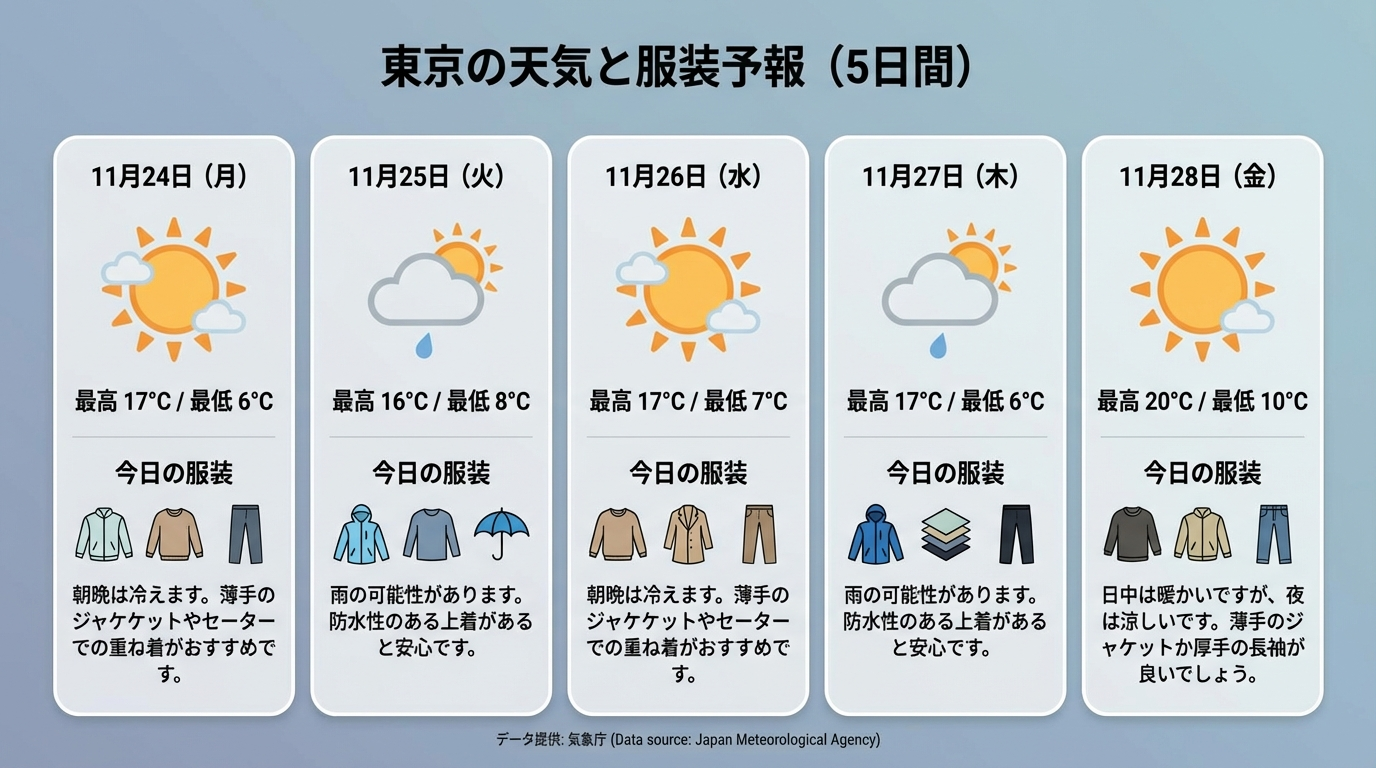

In [ ]:
prompt = "Visualize the current weather forecast for the next 5 days in Tokyo as a clean, modern weather chart in Japanese. add a visual on what i should wear each day"  # @param {type:"string"}
aspect_ratio = "16:9" # @param ["1:1","2:3","3:2","3:4","4:3","4:5","5:4","9:16","16:9","21:9"]

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'], # Image only currently doesn't wortk with grounding
        image_config=types.ImageConfig(
            aspect_ratio=aspect_ratio,
        ),
        tools=[{"google_search": {}}]
    )
)

display_response(response)
save_image(response, 'weather.png')

Don't forget to display the sources:

In [ ]:
from IPython.display import HTML

display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

More on how Search grounding works in the [dedicated guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Search_Grounding.ipynb).

<a name="image_size"></a>
### Generate 4K images

The pro model can generate 1K, 2K or 4K images.

1K and 2K images are priced the same, so spoil yourself :). 4K images are more expensive so only do it when needed (cf. [pricing](https://ai.google.dev/gemini-api/docs/pricing#gemini-2.5-flash-image)).

Here are the corresponding resolution for each aspect ratio and resolution:
| Aspect ratio | 1K resolution | 1K Tokens | 2K resolution | 2K Tokens | 4K resolution | 4K Tokens |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **1:1** | 1024x1024 | 1210 | 2048x2048 | 1210 | 4096x4096 | 2000 |
| **2:3** | 848x1264 | 1210 | 1696x2528 | 1210 | 3392x5056 | 2000 |
| **3:2** | 1264x848 | 1210 | 2528x1696 | 1210 | 5056x3392 | 2000 |
| **3:4** | 896x1200 | 1210 | 1792x2400 | 1210 | 3584x4800 | 2000 |
| **4:3** | 1200x896 | 1210 | 2400x1792 | 1210 | 4800x3584 | 2000 |
| **4:5** | 928x1152 | 1210 | 1856x2304 | 1210 | 3712x4608 | 2000 |
| **5:4** | 1152x928 | 1210 | 2304x1856 | 1210 | 4608x3712 | 2000 |
| **9:16** | 768x1376 | 1210 | 1536x2752 | 1210 | 3072x5504 | 2000 |
| **16:9** | 1376x768 | 1210 | 2752x1536 | 1210 | 5504x3072 | 2000 |
| **21:9** | 1584x672 | 1210 | 3168x1344 | 1210 | 6336x2688 | 2000 |

In [ ]:
prompt = "A photo of an oak tree experiencing every season"  # @param {type:"string"}
aspect_ratio = "1:1" # @param ["1:1","2:3","3:2","3:4","4:3","4:5","5:4","9:16","16:9","21:9"]
resolution = "4K" # @param ["1K", "2K", "4K"]

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'],
        image_config=types.ImageConfig(
            aspect_ratio=aspect_ratio,
            image_size=resolution
        )
    )
)

display_response(response)

<a name="translate"></a>
### Generate or translate image

You can now generate or translate images is over a dozen languages!

In [ ]:
chat = client.chats.create(
    model=PRO_MODEL_ID,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'],
        tools=[{"google_search": {}}]
    )
)

In [ ]:
message = """
Create a sleek, professional, and high-resolution infographic (cheat sheet style) in Japanese.
The design should be modern, tech-oriented, and easy to read.
Organize the following information into clear sections with icons and headers.

# Title: Nano Banana Pro (Gemini 3 Pro Image) 概要

# 1. 導入とコスト
* Platform: Google AI Studio
* Cost: 1K/2K=$0.13, 4K=$0.24 (No Free Tier)
* Batch API: 50% OFF (Max 24h wait)

# 2. 主要な新機能 (Proの強み)
* Thinking Process: 思考の可視化 (include_thoughts=True)
* Search Grounding: リアルタイム検索連携
* 4K Generation: ポスター印刷レベルの高画質
* Advanced Blending: 最大14枚の画像合成
* Polyglot: テキスト生成・翻訳対応

# 3. ベストプラクティス
* Specificity: 色・構図を細かく指定
* Iteration: 会話型で修正
* Positive Prompting: 肯定形で指示
* Cost Saving: Batch APIの活用
"""
aspect_ratio = "16:9" # @param ["1:1","2:3","3:2","3:4","4:3","4:5","5:4","9:16","16:9","21:9"]

response = chat.send_message(message,
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(
            aspect_ratio=aspect_ratio,
        )
    )
)

display_response(response)
save_image(response, "NanoBananaPro.png")

<a name="mix" ></a>

### 最大14枚の画像をミックス！

高忠実度で最大6枚の画像、マイナーチェンジで最大14枚の画像をミックスできるようになりました。例を以下に示します。

![](https://github.com/aicuai/AiCuty/blob/main/img/aicuty-on-stage-real.png?raw=true)


In [ ]:
# Get some images
!wget "https://static.wixstatic.com/media/938eaa_ce2751cc055b49959021c71bf927d834~mv2.jpg" -O "elena.jpg" -q
!wget "https://static.wixstatic.com/media/938eaa_4d0d970924ce45428cad01409f79cc2a~mv2.jpg" -O "mei.jpg" -q
!wget "https://static.wixstatic.com/media/938eaa_4ffdb95af1ad431cae7d52f1b7d4ccd3~mv2.jpg" -O "mina.jpg" -q
!wget "https://static.wixstatic.com/media/938eaa_b722c1e230004711ae5635c8613cc900~mv2.jpg" -O "nao.jpg" -q
!wget "https://static.wixstatic.com/media/938eaa_702f60cd7d5e447ca83414752a4042e7~mv2.jpg" -O "saki.jpg" -q
!wget "https://github.com/aicuai/AiCuty/raw/main/AiCuty-5.png" -O "aicuty.png" -q
!wget "https://github.com/aicuai/AiCuty/blob/main/img/MeiSoleil-SQ.png?raw=true" -O "MeiSoleil-SQ.png" -q



In [ ]:
prompt = "Create a photo realistic cosplay artist photo of a Japanese school idol characters unit \"AiCuty\" (5 pers). Focus on an artistic impression as a music event." # @param {type:"string"}
aspect_ratio = "16:9" # @param ["1:1","2:3","3:2","3:4","4:3","4:5","5:4","9:16","16:9","21:9"]
resolution = "4K" # @param ["1K", "2K", "4K"]

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        prompt,
        PIL.Image.open('saki.jpg'),
        PIL.Image.open('mei.jpg'),
        PIL.Image.open('elena.jpg'),
        PIL.Image.open('mina.jpg'),
        PIL.Image.open('nao.jpg'),
        PIL.Image.open('aicuty.png'),
    ],
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image'],
        image_config=types.ImageConfig(
            aspect_ratio=aspect_ratio,
            image_size=resolution
        ),
    )
)

display_response(response)

## Other cool prompts to test

### Back to the 80s

![](https://github.com/aicuai/AiCuty/blob/main/MeiSoleil/Mei-80.png?raw=true)


In [ ]:
text_prompt = "Create a pop illustration of the person in this image as if they were living in the 1980s. The photograph should capture the distinct fashion, hairstyles, and overall atmosphere of that time period." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('MeiSoleil-SQ.png')
    ]
)

display_response(response)
save_image(response, 'Mei_80s.png')

### Mini-figurine

![](https://github.com/aicuai/AiCuty/blob/main/MeiSoleil/figure.png?raw=true)


In [ ]:
text_prompt = "create a 1/7 scale commercialized figurine of the characters in the picture, in a realistic style, in a real environment. The figurine is placed on a computer desk. The figurine has a round transparent acrylic base, with no text on the base. The content on the computer screen is a 3D modeling process of this figurine. Next to the computer screen is a toy packaging box, designed in a style reminiscent of high-quality collectible figures, printed with original artwork. The packaging features two-dimensional flat illustrations." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('MeiSoleil-SQ.png')
    ]
)

display_response(response)

### Stickers

![](https://github.com/aicuai/AiCuty/blob/main/MeiSoleil/boom.png?raw=true)

![](https://github.com/aicuai/AiCuty/blob/main/MeiSoleil/pow.png?raw=true)



In [1]:
text_prompt = "Create a single sticker in the distinct Pop Art style. The image should feature bold, thick black outlines around all figures, objects, and text. Utilize a limited, flat color palette consisting of vibrant primary and secondary colors, applied in unshaded blocks, but maintain the person skin tone. Incorporate visible Ben-Day dots or halftone patterns to create shading, texture, and depth. The subject should display a dramatic expression. Include stylized text within speech bubbles or dynamic graphic shapes to represent sound effects (onomatopoeia). The overall aesthetic should be clean, graphic, and evoke a mass-produced, commercial art sensibility with a polished finish. The user's face from the uploaded photo must be the main character, ideally with an interesting outline shape that is not square or circular but closer to a dye-cut pattern. white background." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('MeiSoleil-SQ.png')
    ]
)

display_response(response)

### Multi-image fusion
Tip: Combine multiple images into a single ‘collage’ first if you need to go beyond the image upload limit.


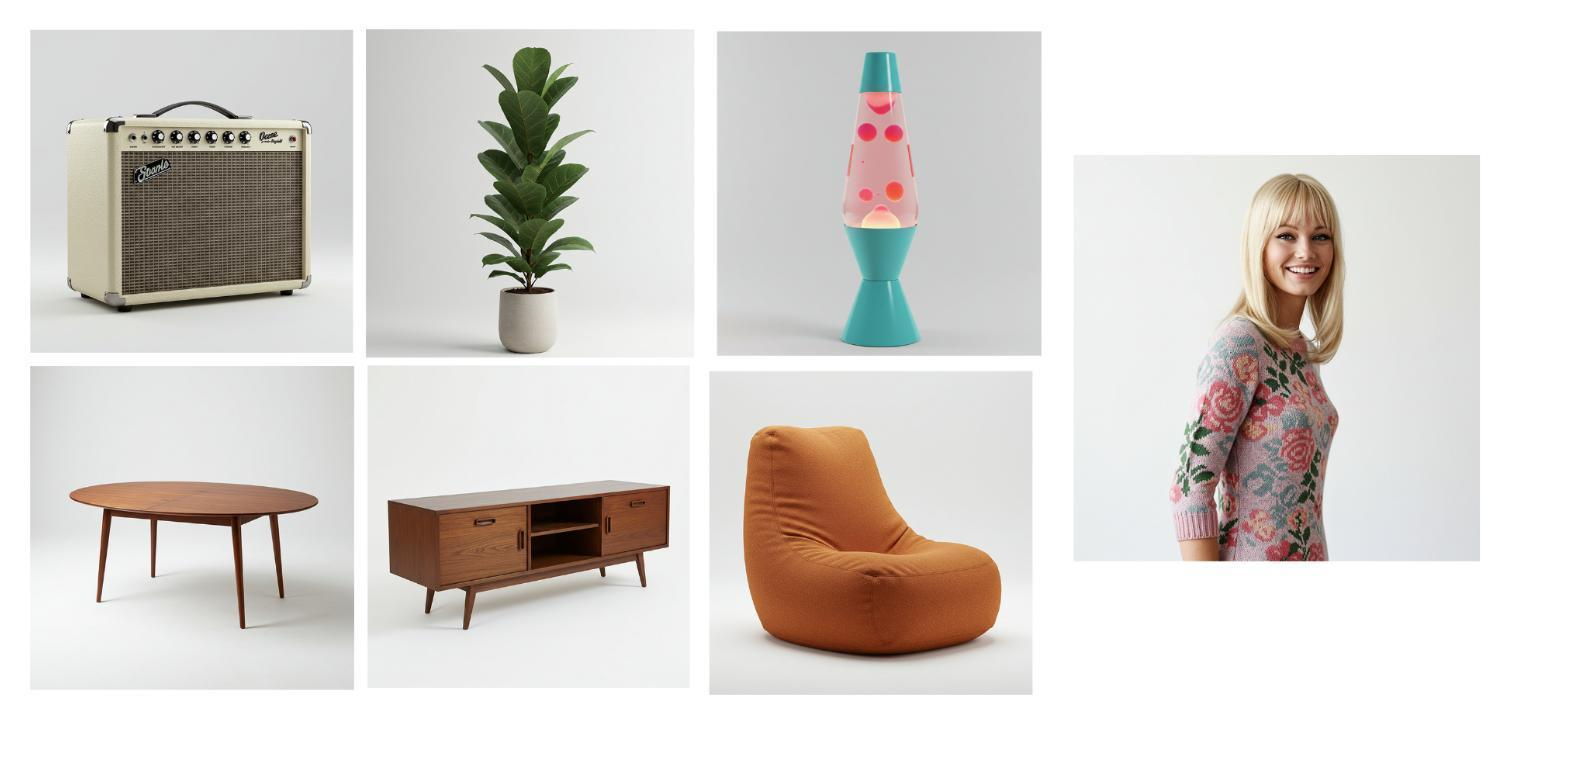

Here's a 60s inspired fashion editorial photoshoot incorporating all the elements from the images you provided:



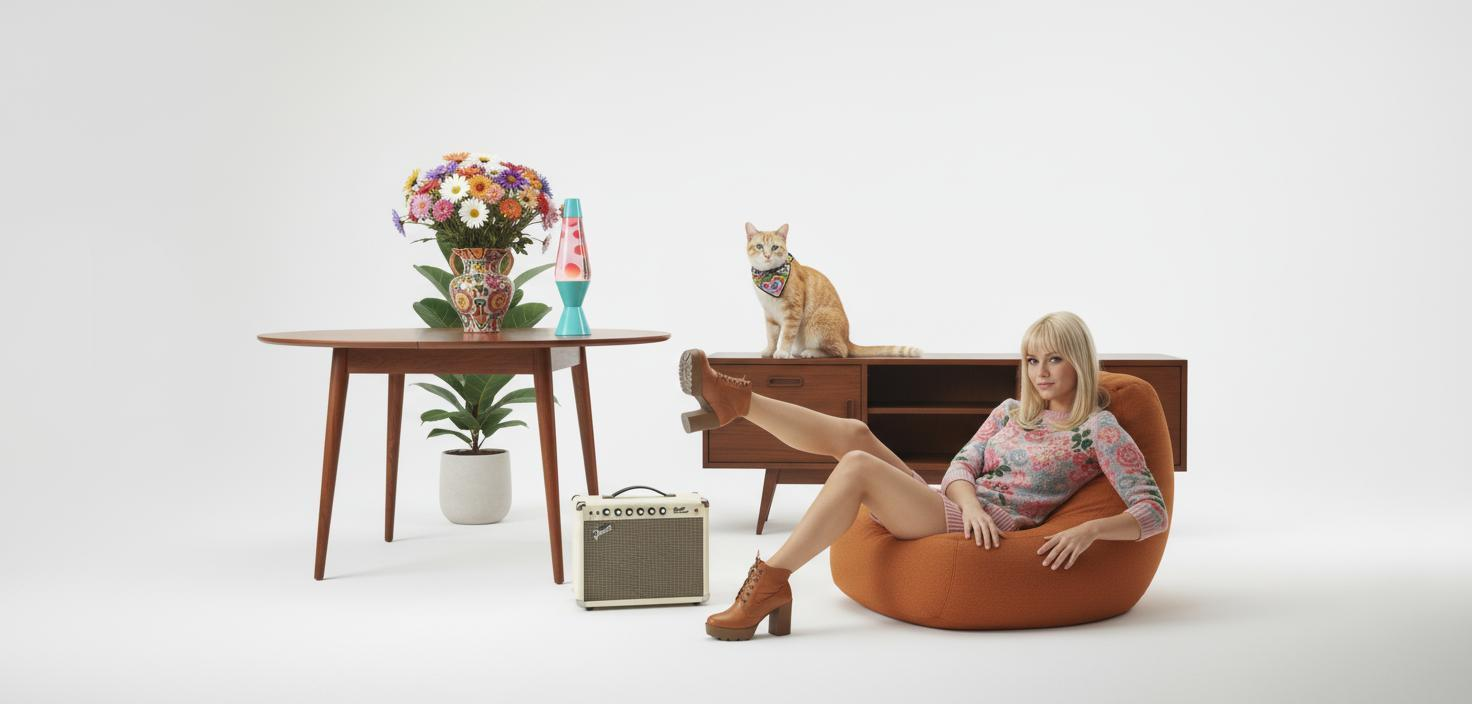

In [ ]:
text_prompt = "Combine everything in these images to create a 60s inspired fashion editorial photoshoot" # @param {type:"string"}

!wget "https://storage.googleapis.com/generativeai-downloads/images/Multiple_images.png" -O "Multiple_images.png" -q
display(Image('Multiple_images.png'))

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('cat.png'),
        PIL.Image.open('Multiple_images.png')
    ]
)

display_response(response)

### Colorize black and white images

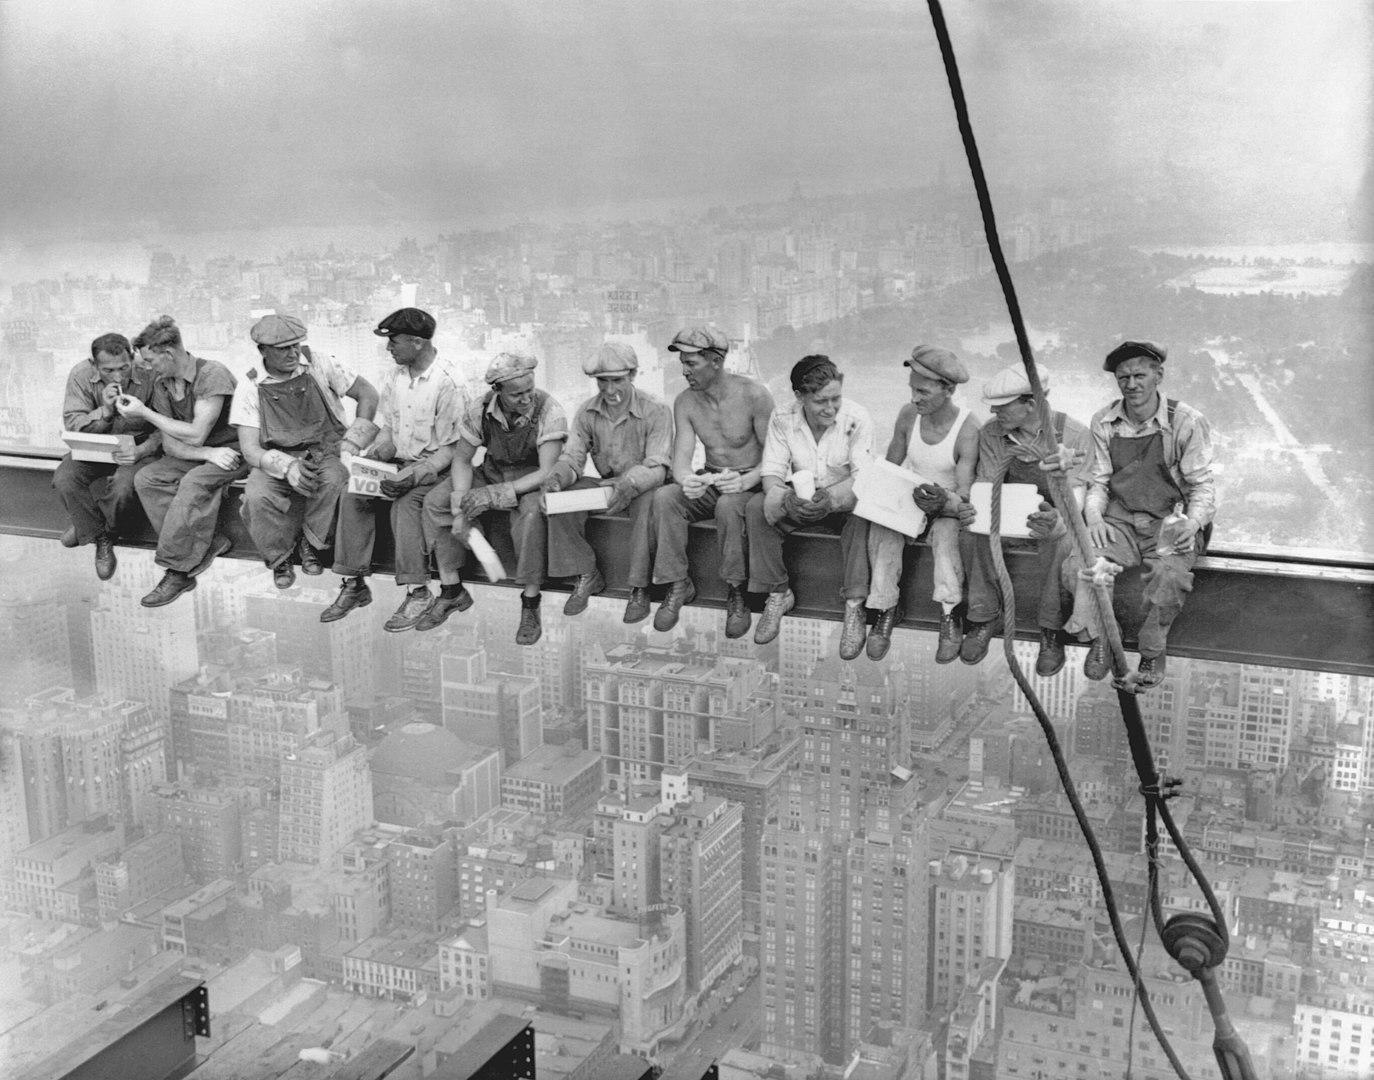

Here's the restored and colorized version of the iconic 1932 image: 

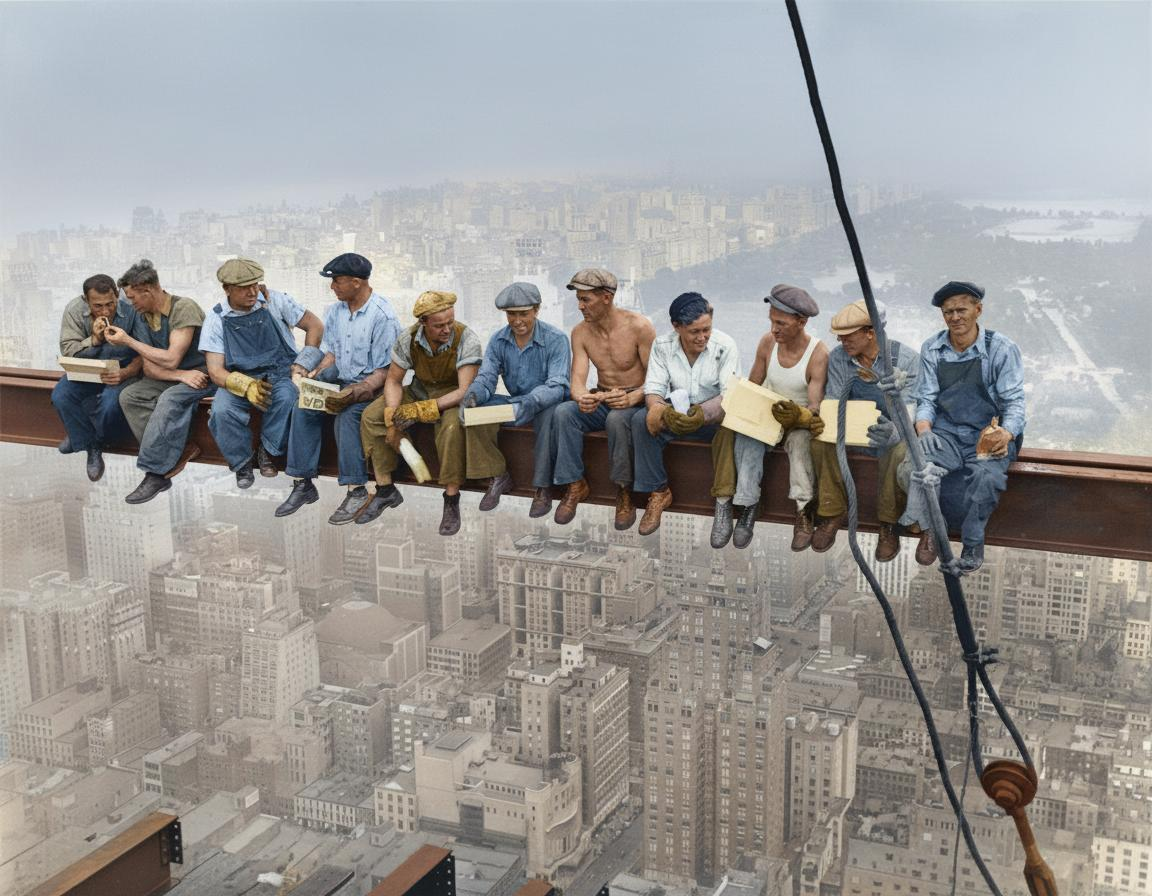

In [ ]:
text_prompt = "Restore and colorize this image from 1932." # @param {type:"string"}

# Thanks to the wikimedia foundation for hosting this historical picture
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Lunch_atop_a_Skyscraper_-_Charles_Clyde_Ebbets.jpg/1374px-Lunch_atop_a_Skyscraper_-_Charles_Clyde_Ebbets.jpg" -O "Lunch_atop_a_Skyscraper.jpg" -q
display(Image('Lunch_atop_a_Skyscraper.jpg'))

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('Lunch_atop_a_Skyscraper.jpg')
    ]
)

display_response(response)

### Google Map transformation


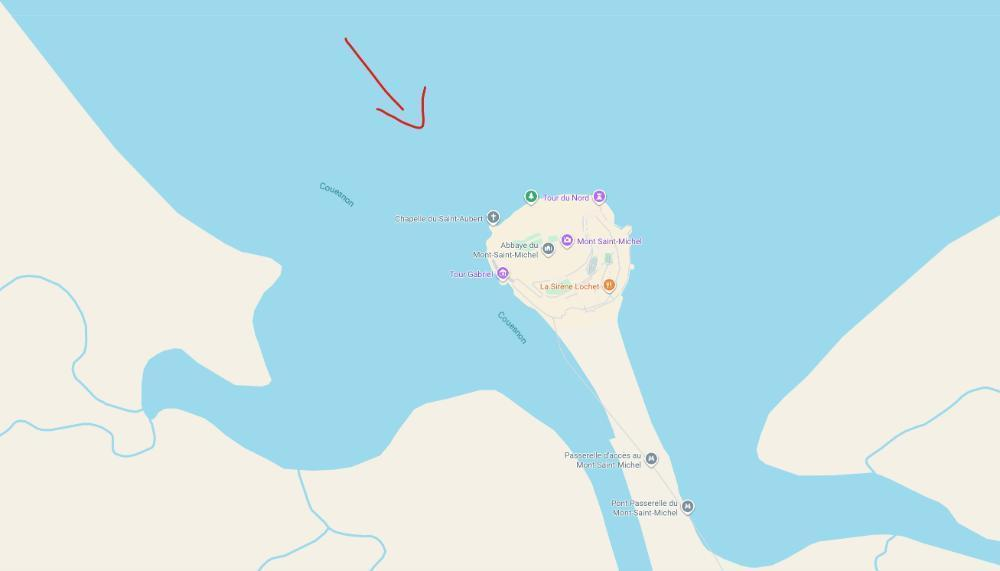

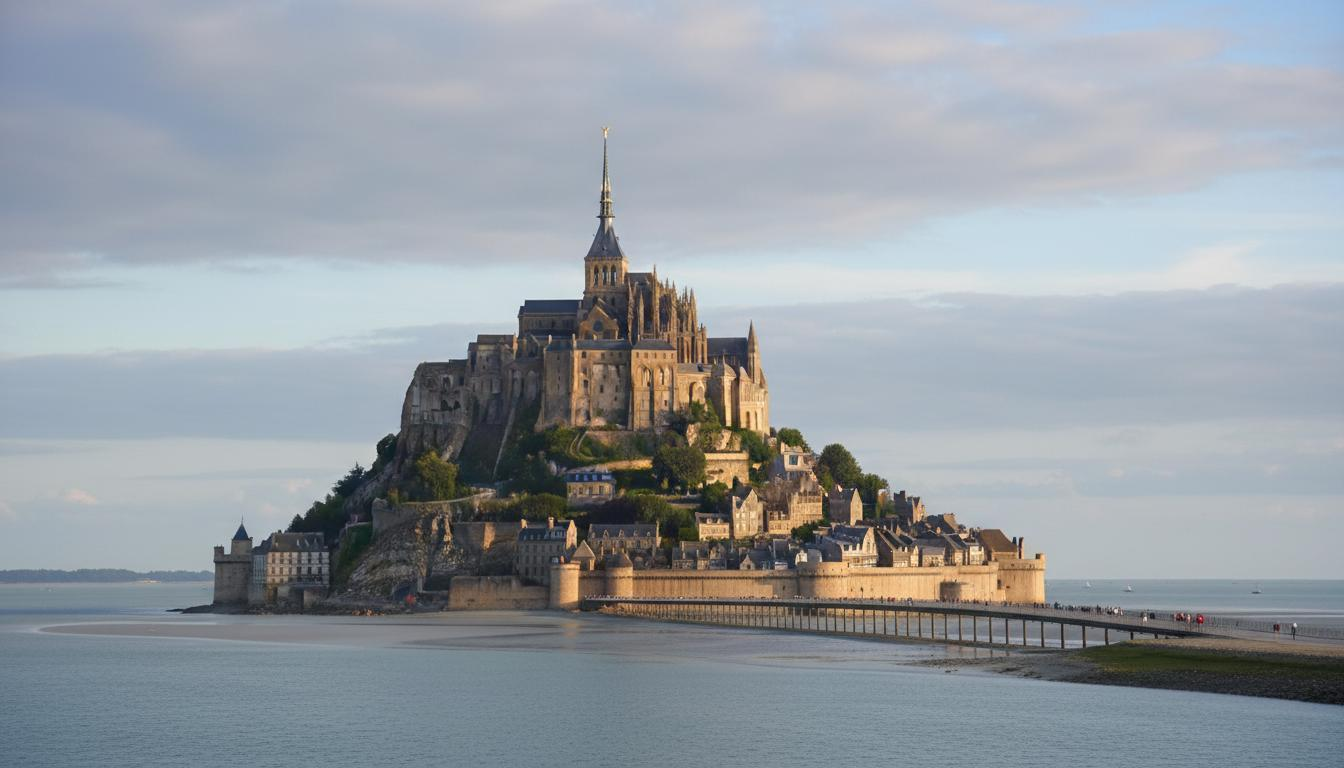

In [ ]:
text_prompt = "Show me what we see from the red arrow" # @param {type:"string"}

!wget "https://storage.googleapis.com/generativeai-downloads/images/Mont_St_Michel.png" -O "Mont_St_Michel.png" -q
display(Image('Mont_St_Michel.png'))

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('Mont_St_Michel.png')
    ]
)

display_response(response)

### Isometric landmark


Here is Mont Saint-Michel in the style of Theme Park! 

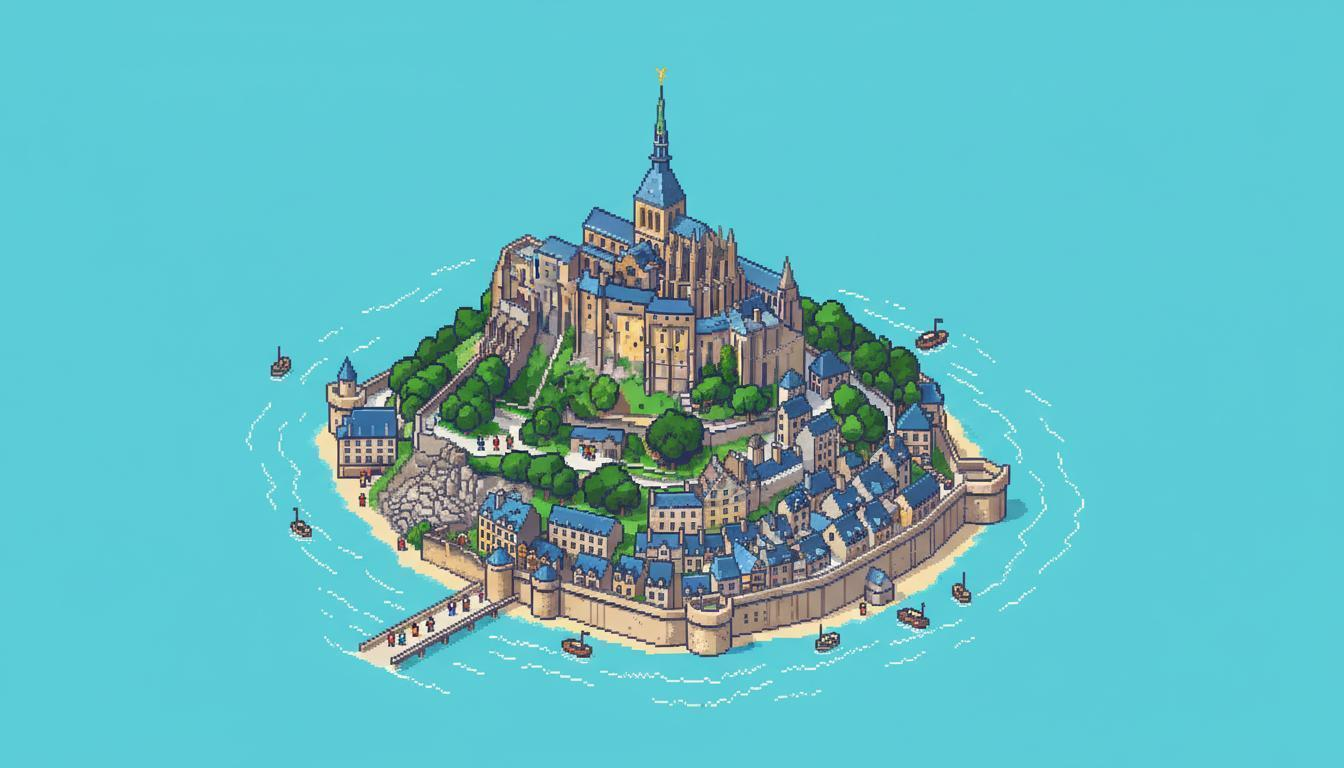

In [ ]:
text_prompt = "Take this location and make the landmark an isometric image (building only), in the style of the game Theme Park." # @param {type:"string"}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open('Mont_St_Michel.png')
    ]
)

display_response(response)

### What does Google know about me? (Pro)


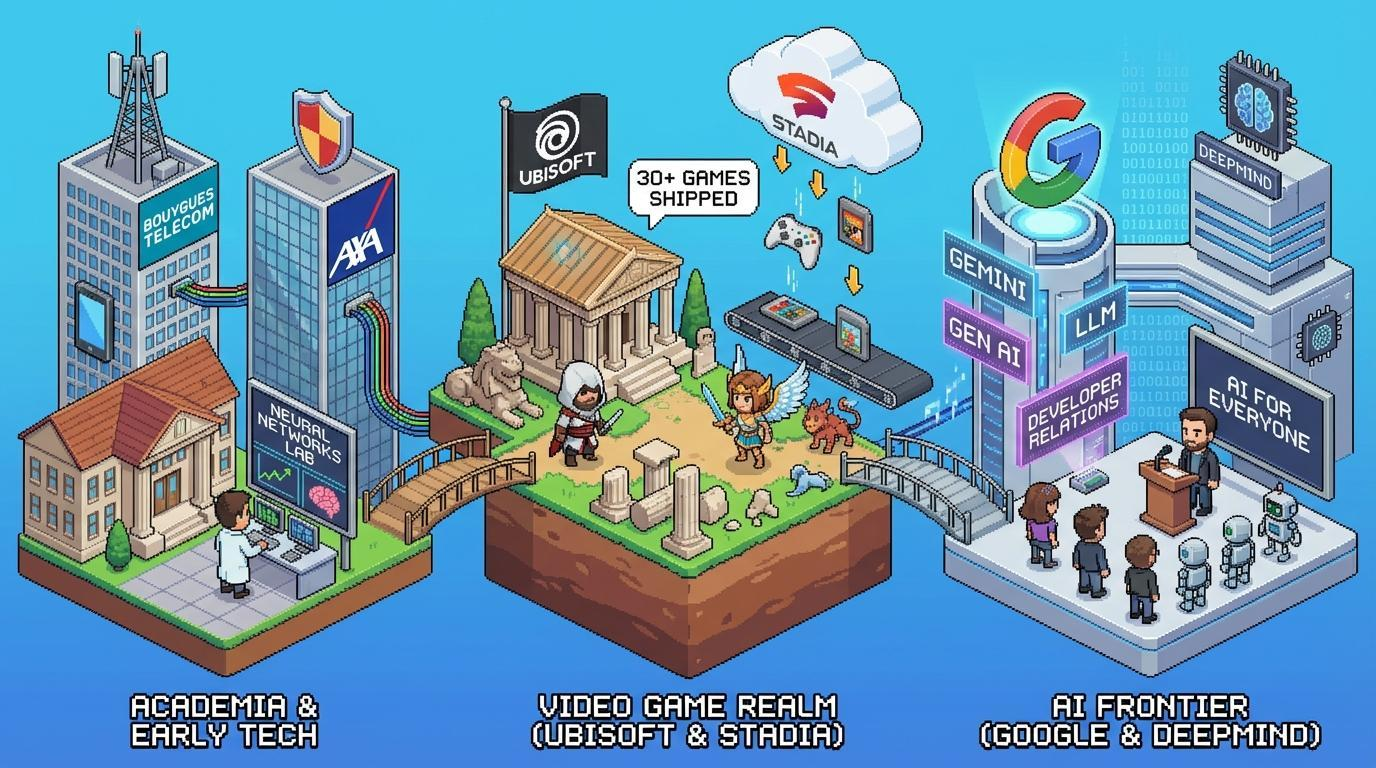

In [ ]:
text_prompt = "Search the web then generate an image of isometric perspective, detailed pixel art that shows the career of Guillaume Vernade" # @param {type:"string"}

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=[
        text_prompt,
    ],
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(
            aspect_ratio="16:9",
        ),
        tools=[{"google_search": {}}]
    )
)

display_response(response)

In [ ]:
display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

### Text-heavy images (Pro)


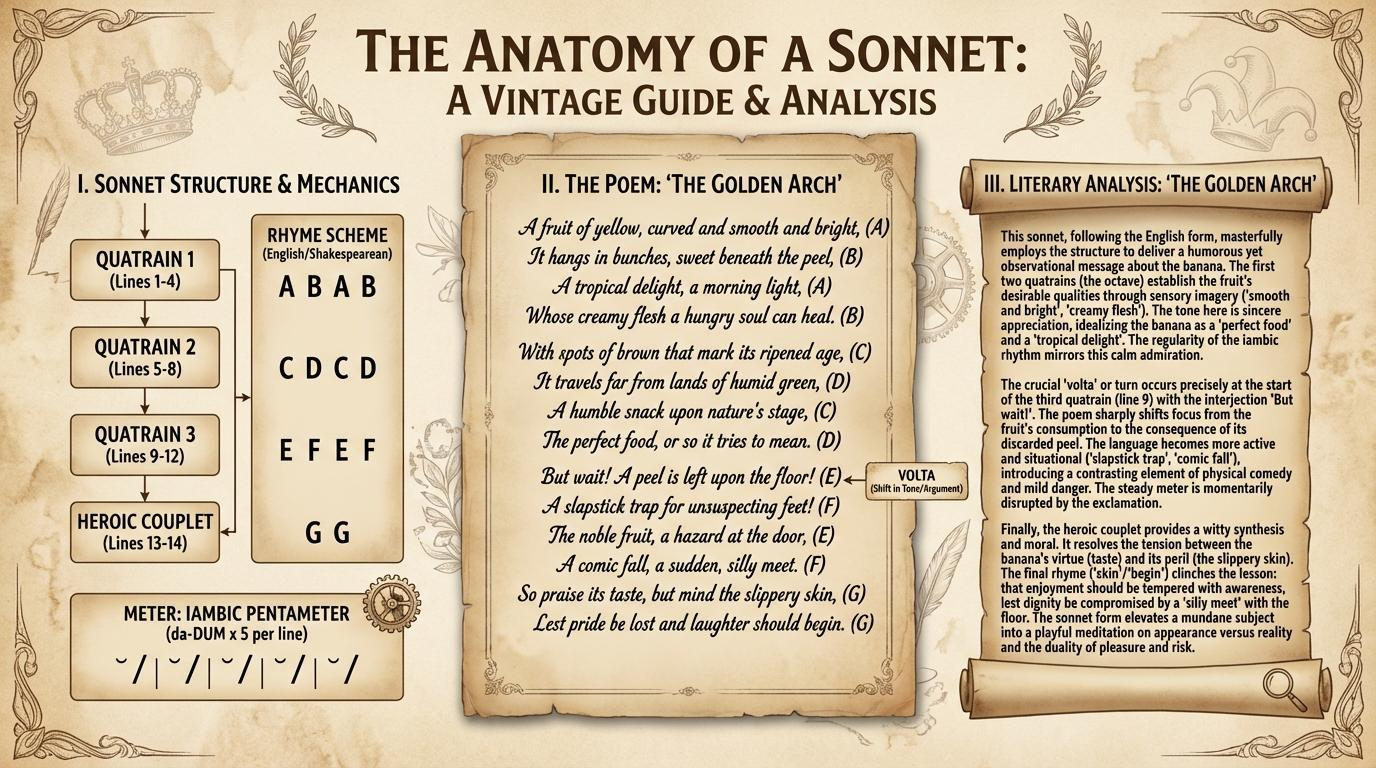

In [ ]:
text_prompt = "Show me an infographic about how sonnets work, using a sonnet about bananas written in it, along with a lengthy literary analysis of the poem. good vintage aesthetics" # @param {type:"string"}

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=[
        text_prompt,
    ],
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(
            aspect_ratio="16:9",
        ),
    )
)

display_response(response)

### Theater program (Pro)


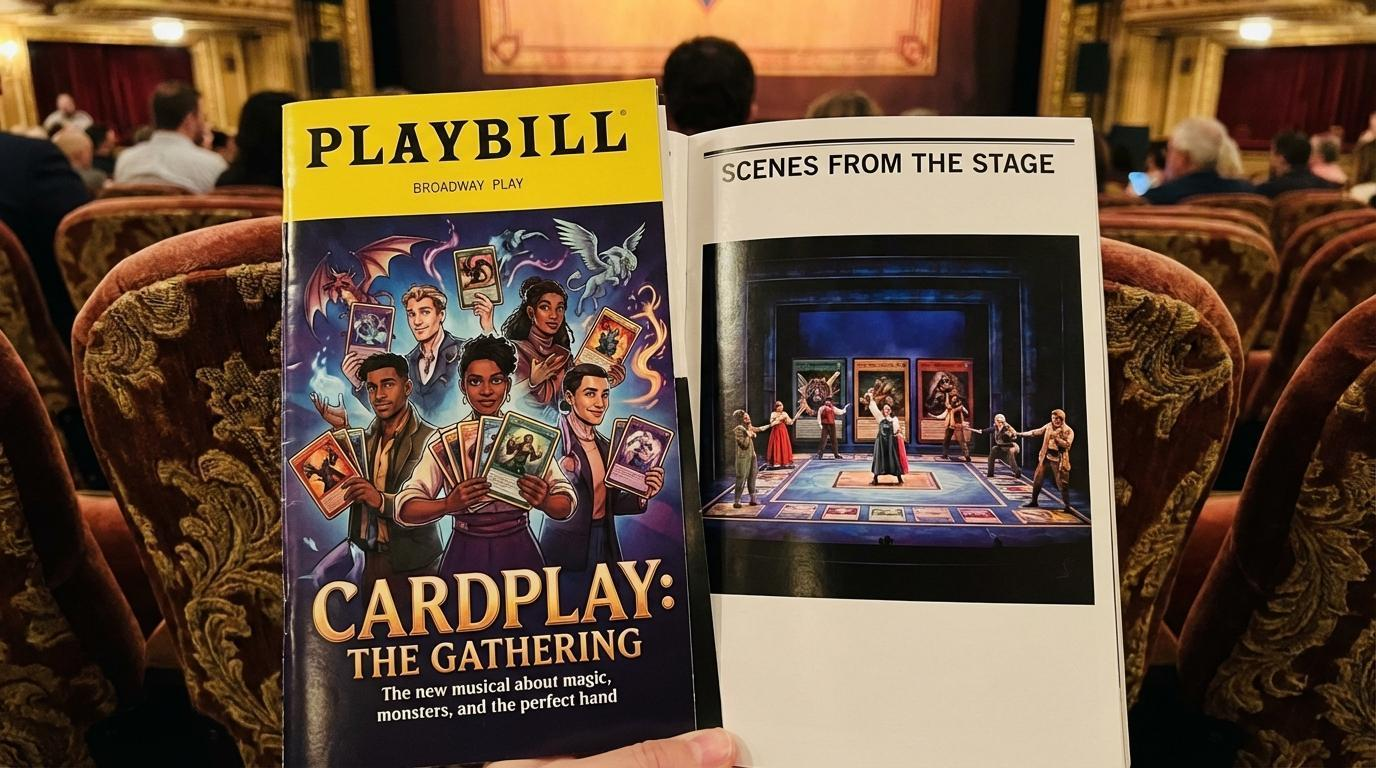

In [ ]:
text_prompt = "A photo of a program for the Broadway show about TCG players on a nice theater seat, it's professional and well made, glossy, we can see the cover and a page showing a photo of the stage." # @param {type:"string"}

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=[
        text_prompt,
    ],
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(
            aspect_ratio="16:9",
        ),
    )
)

display_response(response)

### Famous meme restyling (Pro & chat)


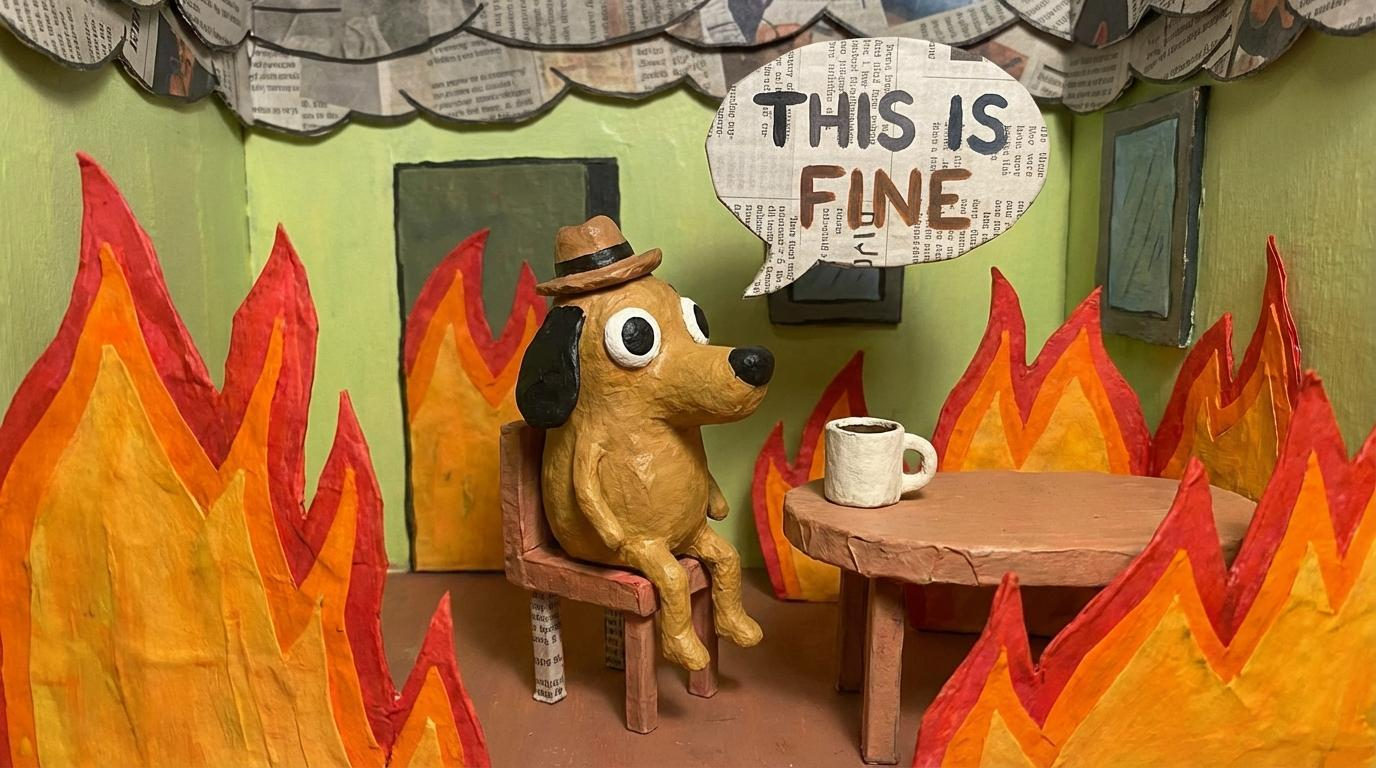

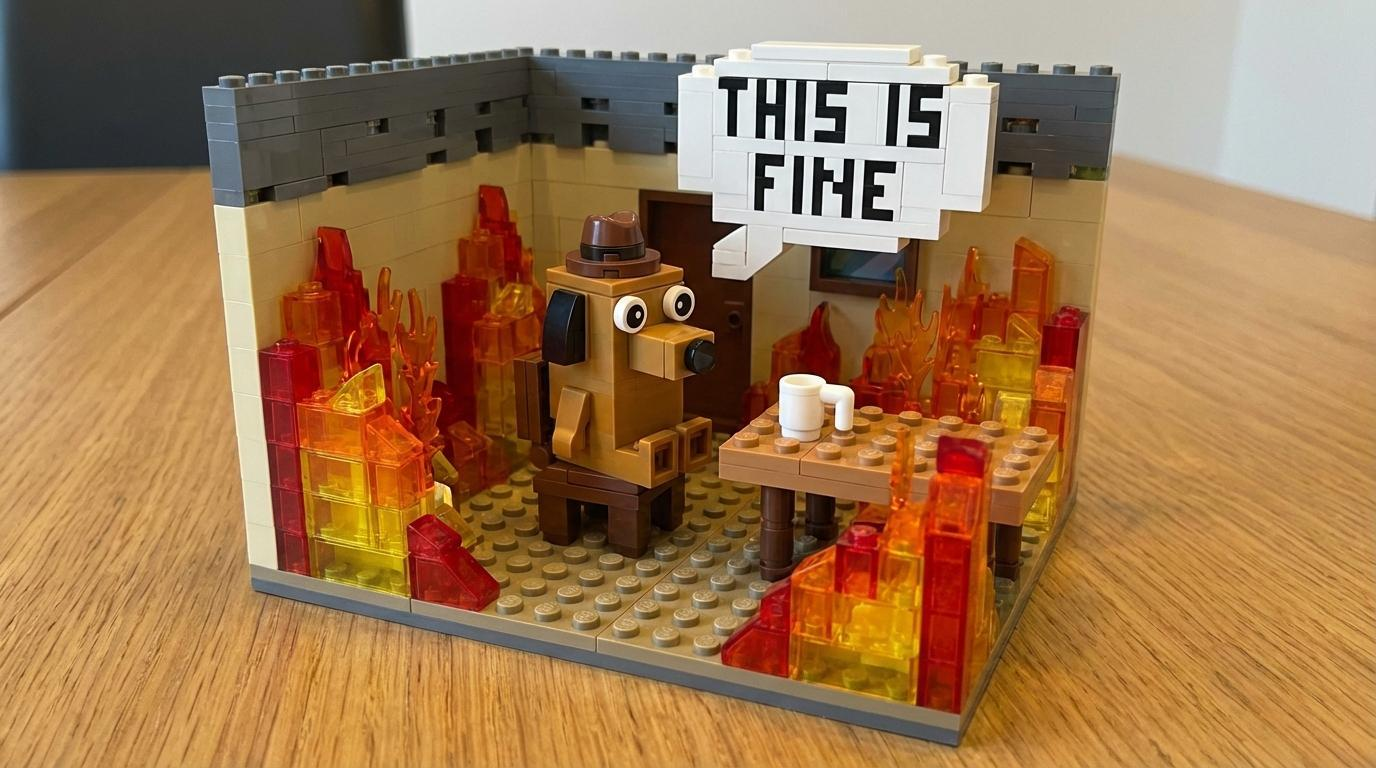

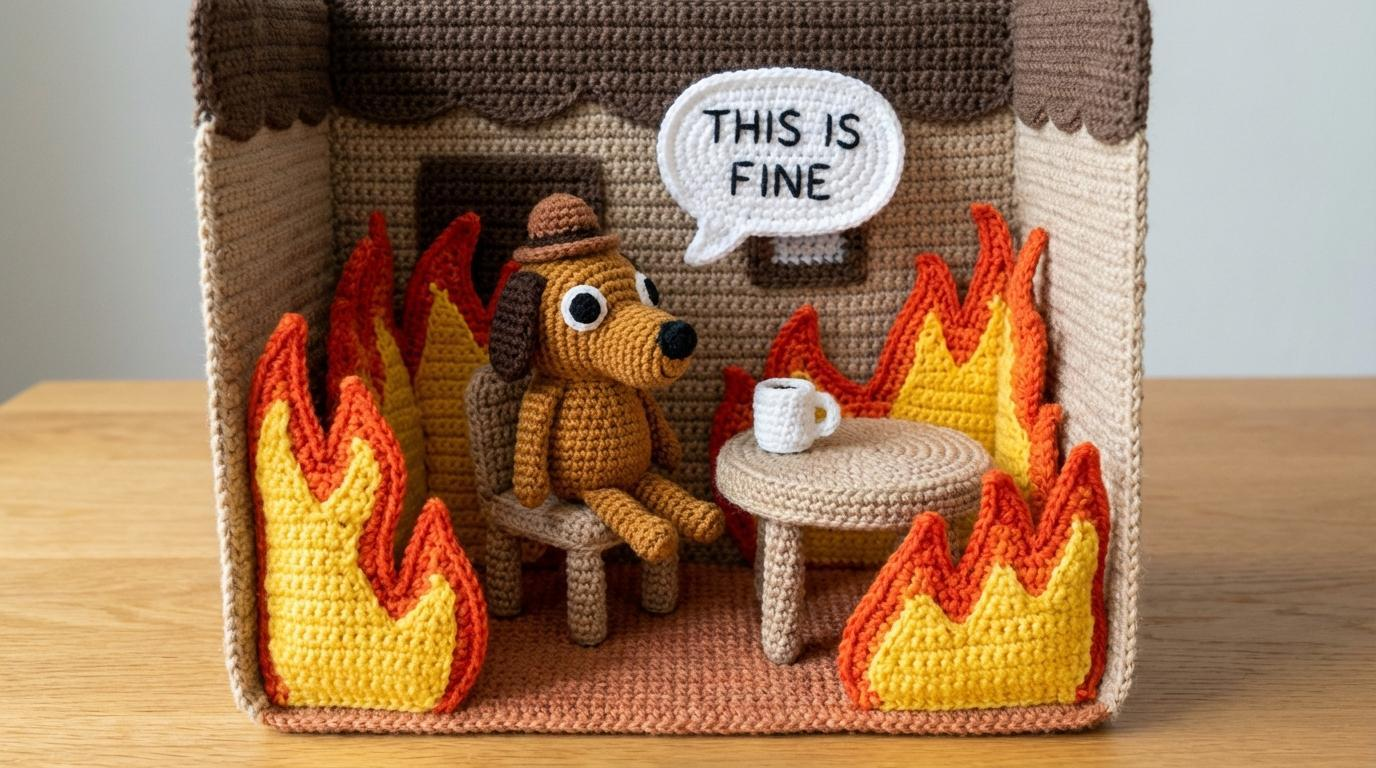

In [ ]:
text_prompt = "There's a vary famous meme about a dog in a house in fire saying \"this is fine\", can you do a papier maché version of it?" # @param {type:"string"}

chat = client.chats.create(
    model=PRO_MODEL_ID,
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(
            aspect_ratio="16:9",
        ),
        tools=[{"google_search": {}}]
    )
)

response = chat.send_message(text_prompt)
display_response(response)

other_style = "Now do a new version with generic building blocks" # @param {type:"string"}

response = chat.send_message(other_style)
display_response(response)

other_style = "What about a crochet version?" # @param {type:"string"}

response = chat.send_message(other_style)
display_response(response)

### Sprites (Pro)

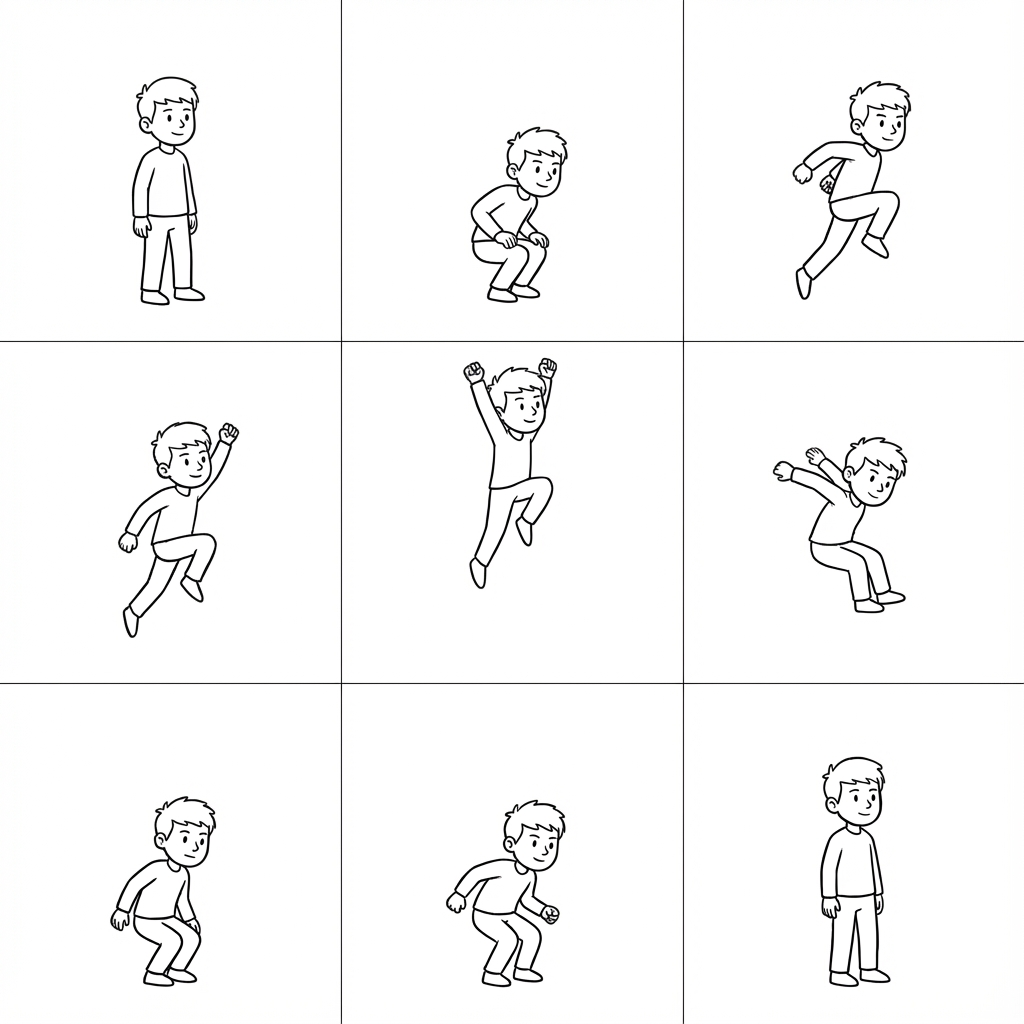

In [ ]:
text_prompt = "Sprite sheet of a jumping illustration, 3x3 grid, white background, sequence, frame by frame animation, square aspect ratio. Follow the structure of the attached reference image exactly." # @param ["Sprite sheet of a jumping illustration, 3x3 grid, white background, sequence, frame by frame animation, square aspect ratio. Follow the structure of the attached reference image exactly.","Sprite sheet of a woman dancing on a drone, 3x3 grid, sequence, frame by frame animation, square aspect ratio. Follow the structure of the attached reference image exactly.","Sprite sheet of oh no, 3x3 grid, white background, sequence, frame by frame animation, square aspect ratio. Follow the structure of the attached reference image exactly."] {"allow-input":true}

!wget "https://storage.googleapis.com/generativeai-downloads/images/grid_3x3_1024.png" -O "grid_3x3_1024.png" -q

response = client.models.generate_content(
    model=PRO_MODEL_ID,
    contents=[
        text_prompt,
        PIL.Image.open("grid_3x3_1024.png")
    ],
    config=types.GenerateContentConfig(
        image_config=types.ImageConfig(
            aspect_ratio="1:1",
        ),
    )
)

display_response(response)
save_image(response, 'sprites.png')

Now let's convert it into a GIF.

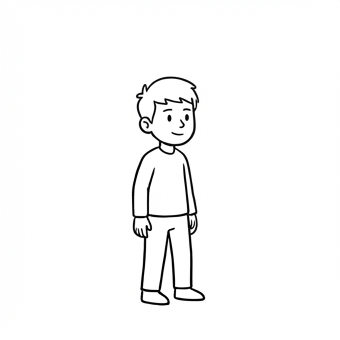

In [ ]:
# @title
import PIL
from IPython.display import display, Image

image = PIL.Image.open('sprites.png')

total_width, total_height = image.size

effective_width = total_width - 2
effective_height = total_height - 2

frame_width = effective_width // 3
frame_height = effective_height // 3

frames = []

for row in range(3):
    for col in range(3):
        left = col * (frame_width + 1)
        upper = row * (frame_height + 1)
        right = left + frame_width
        lower = upper + frame_height

        cropped_frame = image.crop((left, upper, right, lower))

        frames.append(cropped_frame)

frames[0].save(
    'sprite.gif',
    save_all=True,
    append_images=frames[1:],
    duration=200,
    loop=0
)

# Display the GIF by reading its bytes, as suggested
display(Image(data=open('sprite.gif','rb').read()))

## Next Steps
### Useful documentation references:

Check the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#gemini) for more details about the image generation capabilities of the model. To improve your prompting skills, check out the [prompt guide](https://ai.google.dev/gemini-api/docs/image-generation#prompt-guide) for great advices on creating your prompts.

### Check a more complex example
[Illustrate a book ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../examples/Book_illustration.ipynb): Use Gemini to create illustration for an open-source book and audiobook

### Play with the AI Studio apps

AI Studio features a ton of Nano-banana Apps that you can test and customize to your needs. Here are my favorite:
* [Past Forward](https://aistudio.google.com/apps/bundled/past_forward) lets you travel through time
* [Personalized comics](https://aistudio.google.com/apps/bundled/personalized_comics) lets you create comics where YOU are the hero (or the foe, or both 🤯)
* [Pixshop](https://aistudio.google.com/apps/bundled/pixshop), an AI-powered image editor
* [FitCheck](https://aistudio.google.com/apps/bundled/fitcheck), let you virtually try on any clothes
* [Info Genius](https://aistudio.google.com/apps/bundled/info_genius), to create infographics of anything
* And [plenty others](https://aistudio.google.com/apps?source=showcase&showcaseTag=nano-banana)

### Check-out Imagen as well:
The [Imagen](https://ai.google.dev/gemini-api/docs/imagen) model is another way to generate images. Check out the [Get Started with Imagen notebook ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_imagen.ipynb) to start playing with it too.

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Video_understanding.ipynb) one for video examples.
